# 28. 総合演習プロジェクト - Customer Churn Prediction (Comprehensive ML Project)

## 概要
これまで学んだ全ての技術を統合し、実践的な機械学習プロジェクトを完成させます。顧客離反予測（Customer Churn Prediction）という実務で頻出する問題を通じて、データサイエンティストとしての総合力を磨きます。

## プロジェクトの目標
通信会社の顧客離反を予測するモデルを構築し、以下を達成します：
- ✅ ROC-AUC > 0.85を目指す
- ✅ 解釈可能な特徴量を作成する
- ✅ 複数のアルゴリズムを比較する
- ✅ 適切な検証戦略を実装する
- ✅ アンサンブルで性能を向上させる
- ✅ ビジネスへの提言をまとめる

## 使用する技術（これまで学んだ全て！）

### Phase 1-3: 基礎
- データシミュレーション
- 前処理と特徴量エンジニアリング
- モデル評価指標

### Phase 4-6: 機械学習モデル
- 線形モデル
- 決定木とアンサンブル
- SVM

### Phase 7: 高度なテクニック
- Optunaハイパーパラメータ最適化
- SHAPモデル解釈
- Stackingアンサンブル

### Phase 8: 専門トピック
- 不均衡データ対策（SMOTE、Focal Loss）
- 時系列特徴量
- カテゴリカル変数エンコーディング

### Phase 9: 最終プロジェクト
- Tabularディープラーニング
- Kaggle完全ワークフロー

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, TargetEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# 不均衡データ対策
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

# ハイパーパラメータ最適化
import optuna

# モデル解釈
import shap

import warnings
warnings.filterwarnings('ignore')

# 設定
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
np.random.seed(42)

print("✅ すべてのライブラリが正常にインポートされました")
print("\nこれから始まる総合プロジェクトで、これまで学んだすべての技術を活用します！")

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',  # macOS
        'Yu Gothic', 'MS Gothic',  # Windows
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',  # Linux
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"Japanese font: {font_used}")


/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ すべてのライブラリが正常にインポートされました

これから始まる総合プロジェクトで、これまで学んだすべての技術を活用します！


## 1. ビジネス課題の理解

### 背景

あなたは大手通信会社のデータサイエンスチームに所属しています。

### 課題

**顧客離反率（Churn Rate）が高く、収益に悪影響を与えています。**

### ビジネス目標

1. **離反リスクの高い顧客を特定**
   - 離反する前にリテンション施策を実施
   - コストを抑えて顧客を維持

2. **離反の主要因を解明**
   - どの要因が離反に最も影響するか
   - サービス改善の指針を得る

3. **ROI（投資対効果）の最大化**
   - リテンションキャンペーンの効果を予測
   - 限られた予算を最適配分

### データサイエンスの役割

- 離反予測モデルの構築
- 予測根拠の説明（解釈可能性）
- ビジネスへの actionable insights

### 評価指標の選定

今回の課題では、**ROC-AUC**を主要な評価指標とします。

**理由**:
- 閾値に依存しない総合的な性能評価
- クラス不均衡に対して比較的ロバスト
- ビジネス側が離反確率（予測スコア）でランキングできる

## 2. データの生成と理解

実際のプロジェクトでは、データを取得・結合する必要がありますが、
今回は学習用にリアルな顧客データを生成します。

In [2]:
# リアルな顧客離反データの生成
np.random.seed(42)
n_samples = 10000

# 1. 人口統計学的特徴量
data = {
    'customer_id': range(1, n_samples + 1),
    'age': np.random.randint(18, 80, n_samples),
    'gender': np.random.choice(['Male', 'Female'], n_samples),
    'senior_citizen': np.random.choice([0, 1], n_samples, p=[0.85, 0.15]),
    
    # 2. サービス利用状況
    'tenure_months': np.random.randint(1, 73, n_samples),  # 契約期間（月）
    'contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], 
                                 n_samples, p=[0.55, 0.25, 0.20]),
    'payment_method': np.random.choice(['Electronic check', 'Mailed check', 
                                       'Bank transfer', 'Credit card'], n_samples),
    'paperless_billing': np.random.choice(['Yes', 'No'], n_samples, p=[0.6, 0.4]),
    
    # 3. サービスオプション
    'phone_service': np.random.choice(['Yes', 'No'], n_samples, p=[0.9, 0.1]),
    'multiple_lines': np.random.choice(['Yes', 'No', 'No phone service'], 
                                      n_samples, p=[0.5, 0.4, 0.1]),
    'internet_service': np.random.choice(['DSL', 'Fiber optic', 'No'], 
                                         n_samples, p=[0.35, 0.45, 0.20]),
    'online_security': np.random.choice(['Yes', 'No', 'No internet service'], n_samples),
    'online_backup': np.random.choice(['Yes', 'No', 'No internet service'], n_samples),
    'device_protection': np.random.choice(['Yes', 'No', 'No internet service'], n_samples),
    'tech_support': np.random.choice(['Yes', 'No', 'No internet service'], n_samples),
    'streaming_tv': np.random.choice(['Yes', 'No', 'No internet service'], n_samples),
    'streaming_movies': np.random.choice(['Yes', 'No', 'No internet service'], n_samples),
    
    # 4. 料金情報
    'monthly_charges': np.random.uniform(18.0, 120.0, n_samples),
}

df = pd.DataFrame(data)

# Total Chargesを計算（tenure × monthly charges + ノイズ）
df['total_charges'] = df['tenure_months'] * df['monthly_charges'] + \
                      np.random.normal(0, 100, n_samples)
df['total_charges'] = df['total_charges'].clip(lower=0)

# 5. ターゲット変数（Churn）の生成
# 複数の要因から離反確率を計算
churn_prob = (
    0.7 - (df['tenure_months'] / 100) +  # 契約期間が短いほど離反しやすい
    0.3 * (df['contract'] == 'Month-to-month').astype(int) +  # 月契約は離反しやすい
    0.2 * (df['internet_service'] == 'Fiber optic').astype(int) +  # 光ファイバーは離反しやすい（高価格）
    0.15 * (df['payment_method'] == 'Electronic check').astype(int) +  # 電子チェックは離反しやすい
    0.1 * (df['paperless_billing'] == 'Yes').astype(int) +
    (df['monthly_charges'] - 70) / 200 +  # 料金が高いほど離反しやすい
    -0.15 * (df['tech_support'] == 'Yes').astype(int) +  # テクサポートあると離反しにくい
    -0.15 * (df['online_security'] == 'Yes').astype(int) +  # セキュリティサービスあると離反しにくい
    np.random.normal(0, 0.2, n_samples)  # ランダムノイズ
)

# 確率を0-1にクリップ
churn_prob = np.clip(churn_prob, 0, 1)

# ベルヌーイ分布でChurnを生成（約25%離反）
df['churn'] = (np.random.random(n_samples) < churn_prob * 0.4).astype(int)

print(f"データサイズ: {df.shape}")
print(f"\nChurn分布:")
print(df['churn'].value_counts())
print(f"\nChurn率: {df['churn'].mean():.2%}")
print(f"\nデータの先頭:")
print(df.head(10))

データサイズ: (10000, 20)

Churn分布:
churn
0    7752
1    2248
Name: count, dtype: int64

Churn率: 22.48%

データの先頭:
   customer_id  age  gender  senior_citizen  tenure_months        contract  \
0            1   56  Female               0             48  Month-to-month   
1            2   69  Female               0             63  Month-to-month   
2            3   46    Male               0             51  Month-to-month   
3            4   32    Male               0             45        Two year   
4            5   60    Male               0             33        Two year   
5            6   25    Male               0             60  Month-to-month   
6            7   78    Male               0              2  Month-to-month   
7            8   38  Female               0             13  Month-to-month   
8            9   56    Male               0             66  Month-to-month   
9           10   75    Male               1             57        Two year   

     payment_method paperless_bill

## 3. 探索的データ分析（EDA）

データを深く理解するためのEDAを実施します。

In [3]:
# 基本統計量
print("=" * 80)
print("数値変数の統計量")
print("=" * 80)
print(df.describe())

print("\n" + "=" * 80)
print("カテゴリカル変数の情報")
print("=" * 80)
categorical_cols = df.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())

数値変数の統計量
       customer_id           age  senior_citizen  tenure_months  \
count  10000.00000  10000.000000    10000.000000   10000.000000   
mean    5000.50000     48.798400        0.149000      36.461700   
std     2886.89568     17.903223        0.356106      20.708129   
min        1.00000     18.000000        0.000000       1.000000   
25%     2500.75000     34.000000        0.000000      19.000000   
50%     5000.50000     49.000000        0.000000      36.000000   
75%     7500.25000     64.000000        0.000000      54.000000   
max    10000.00000     79.000000        1.000000      72.000000   

       monthly_charges  total_charges         churn  
count     10000.000000   10000.000000  10000.000000  
mean         69.179821    2525.845828      0.224800  
std          29.554238    1904.882659      0.417471  
min          18.005803       0.000000      0.000000  
25%          43.836295    1007.756702      0.000000  
50%          69.033809    2055.252587      0.000000  
75%      

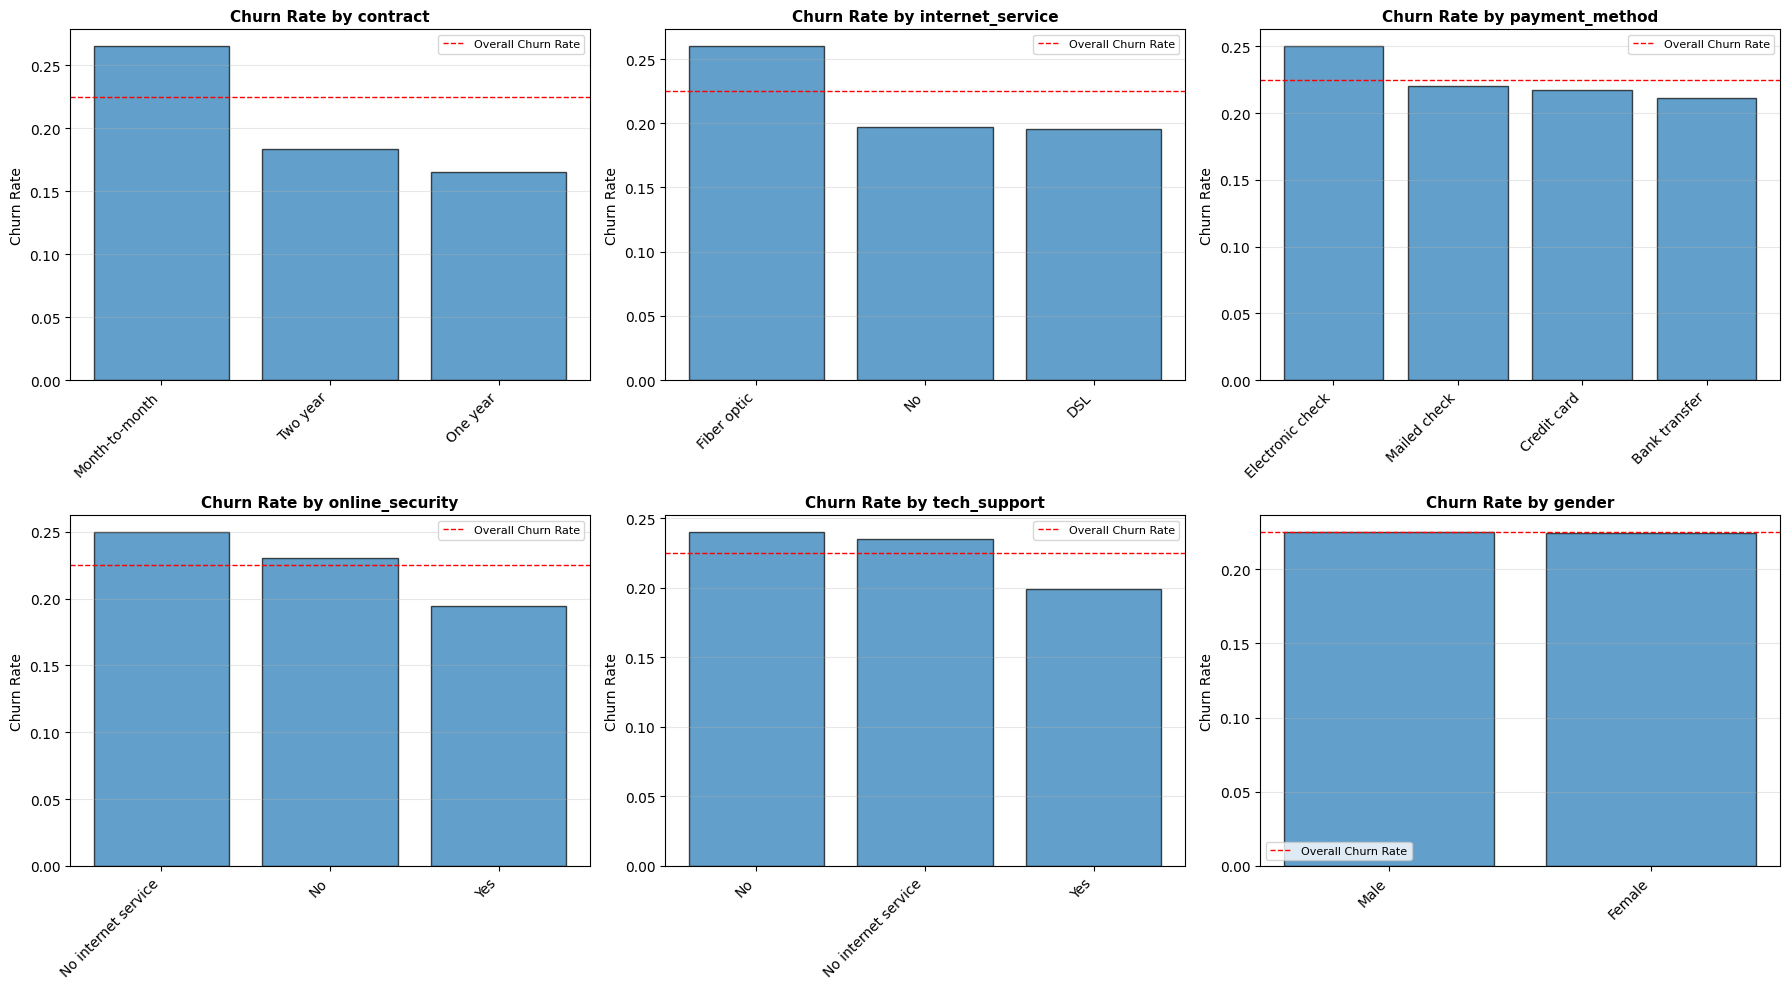


💡 主要な発見:
- Month-to-month契約の離反率が最も高い
- Electronic checkでの支払いは離反率が高い
- Tech supportやOnline securityがないと離反しやすい


In [4]:
# Churn率の可視化（カテゴリカル変数別）
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

key_categorical = ['contract', 'internet_service', 'payment_method', 
                  'online_security', 'tech_support', 'gender']

for idx, col in enumerate(key_categorical):
    churn_rate = df.groupby(col)['churn'].mean().sort_values(ascending=False)
    
    axes[idx].bar(range(len(churn_rate)), churn_rate.values, 
                 alpha=0.7, edgecolor='black')
    axes[idx].set_xticks(range(len(churn_rate)))
    axes[idx].set_xticklabels(churn_rate.index, rotation=45, ha='right')
    axes[idx].set_ylabel('Churn Rate', fontsize=10)
    axes[idx].set_title(f'Churn Rate by {col}', fontsize=11, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].axhline(df['churn'].mean(), color='red', linestyle='--', 
                     linewidth=1, label='Overall Churn Rate')
    axes[idx].legend(fontsize=8)

plt.tight_layout()
plt.show()

print("\n💡 主要な発見:")
print("- Month-to-month契約の離反率が最も高い")
print("- Electronic checkでの支払いは離反率が高い")
print("- Tech supportやOnline securityがないと離反しやすい")

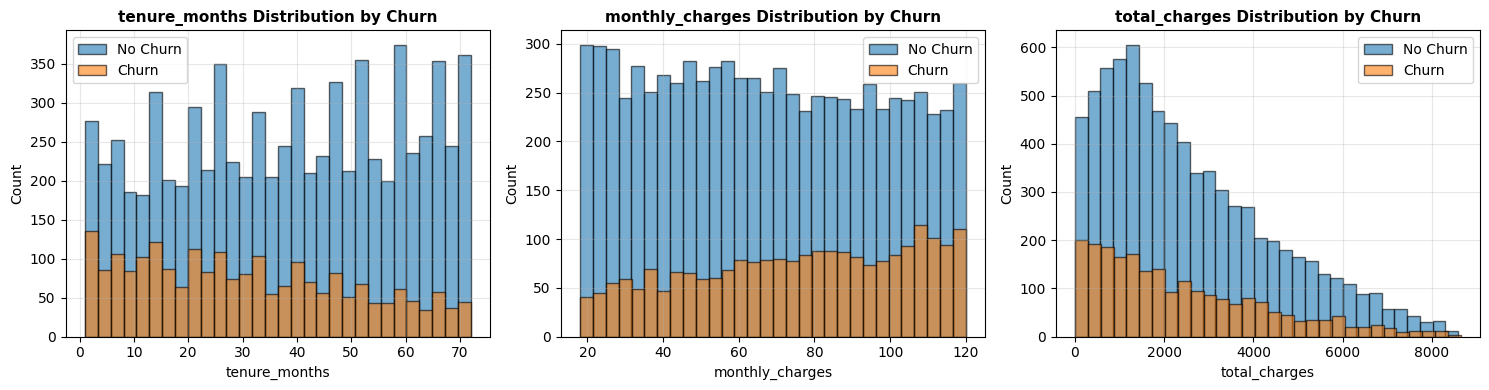


💡 観察:
- 契約期間（tenure）が短い顧客ほど離反しやすい
- 月額料金（monthly charges）が高い顧客は離反しやすい傾向
- Total chargesは契約期間と相関が高い


In [5]:
# 数値変数とChurnの関係
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

numeric_features = ['tenure_months', 'monthly_charges', 'total_charges']

for idx, col in enumerate(numeric_features):
    axes[idx].hist(df[df['churn']==0][col], bins=30, alpha=0.6, 
                  label='No Churn', edgecolor='black')
    axes[idx].hist(df[df['churn']==1][col], bins=30, alpha=0.6, 
                  label='Churn', edgecolor='black')
    axes[idx].set_xlabel(col, fontsize=10)
    axes[idx].set_ylabel('Count', fontsize=10)
    axes[idx].set_title(f'{col} Distribution by Churn', fontsize=11, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 観察:")
print("- 契約期間（tenure）が短い顧客ほど離反しやすい")
print("- 月額料金（monthly charges）が高い顧客は離反しやすい傾向")
print("- Total chargesは契約期間と相関が高い")

## 4. データ前処理と特徴量エンジニアリング

これまで学んだテクニックを駆使して、強力な特徴量を作成します。

In [6]:
def create_features(df):
    """
    包括的な特徴量エンジニアリング
    """
    df_fe = df.copy()
    
    # 1. 既存特徴量の変換
    df_fe['tenure_years'] = df_fe['tenure_months'] / 12
    df_fe['log_monthly_charges'] = np.log1p(df_fe['monthly_charges'])
    df_fe['log_total_charges'] = np.log1p(df_fe['total_charges'])
    
    # 2. 比率特徴量
    df_fe['monthly_to_total_ratio'] = df_fe['monthly_charges'] / (df_fe['total_charges'] + 1)
    df_fe['charges_per_month'] = df_fe['total_charges'] / (df_fe['tenure_months'] + 1)
    
    # 3. Binning特徴量
    df_fe['tenure_group'] = pd.cut(df_fe['tenure_months'], 
                                   bins=[0, 12, 24, 48, 72], 
                                   labels=['0-12', '12-24', '24-48', '48+'])
    df_fe['charges_group'] = pd.qcut(df_fe['monthly_charges'], 
                                     q=4, labels=['Low', 'Medium', 'High', 'Very High'])
    
    # 4. サービス数のカウント
    services = ['phone_service', 'multiple_lines', 'online_security', 
               'online_backup', 'device_protection', 'tech_support',
               'streaming_tv', 'streaming_movies']
    
    df_fe['num_services'] = 0
    for service in services:
        df_fe['num_services'] += (df_fe[service] == 'Yes').astype(int)
    
    # 5. 契約・支払いリスクフラグ
    df_fe['is_high_risk_contract'] = (df_fe['contract'] == 'Month-to-month').astype(int)
    df_fe['is_high_risk_payment'] = (df_fe['payment_method'] == 'Electronic check').astype(int)
    
    # 6. セキュリティ関連サービスの有無
    df_fe['has_security'] = ((df_fe['online_security'] == 'Yes') | 
                            (df_fe['tech_support'] == 'Yes')).astype(int)
    
    # 7. インターネット利用度
    df_fe['internet_usage_score'] = (
        (df_fe['online_security'] == 'Yes').astype(int) +
        (df_fe['online_backup'] == 'Yes').astype(int) +
        (df_fe['device_protection'] == 'Yes').astype(int) +
        (df_fe['streaming_tv'] == 'Yes').astype(int) +
        (df_fe['streaming_movies'] == 'Yes').astype(int)
    )
    
    # 8. 顧客価値スコア（LTV proxy）
    df_fe['customer_value_score'] = (
        df_fe['tenure_months'] * df_fe['monthly_charges'] / 1000
    )
    
    return df_fe

# 特徴量エンジニアリングを適用
df_enhanced = create_features(df)

print(f"元の特徴量数: {df.shape[1] - 2}")
print(f"拡張後の特徴量数: {df_enhanced.shape[1] - 2}")
print(f"追加された特徴量: {df_enhanced.shape[1] - df.shape[1]}")

# 新特徴量のリスト
new_features = set(df_enhanced.columns) - set(df.columns)
print(f"\n新しい特徴量:")
for feat in sorted(new_features):
    print(f"  - {feat}")

元の特徴量数: 18
拡張後の特徴量数: 31
追加された特徴量: 13

新しい特徴量:
  - charges_group
  - charges_per_month
  - customer_value_score
  - has_security
  - internet_usage_score
  - is_high_risk_contract
  - is_high_risk_payment
  - log_monthly_charges
  - log_total_charges
  - monthly_to_total_ratio
  - num_services
  - tenure_group
  - tenure_years


In [7]:
# カテゴリカル変数のエンコーディング（Target Encoding）
# まずデータ分割
X = df_enhanced.drop(['customer_id', 'churn'], axis=1)
y = df_enhanced['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"訓練データ: {X_train.shape}")
print(f"テストデータ: {X_test.shape}")
print(f"\nChurn率:")
print(f"- 訓練: {y_train.mean():.2%}")
print(f"- テスト: {y_test.mean():.2%}")

# カテゴリカル変数のリスト
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nカテゴリカル変数: {len(categorical_features)}個")
print(categorical_features)

# scikit-learn 1.6の組み込みTargetEncoderを使用
if len(categorical_features) > 0:
    # カテゴリカル変数をまとめてエンコード
    X_train_cat = X_train[categorical_features]
    X_test_cat = X_test[categorical_features]
    
    # 数値変数
    numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    X_train_num = X_train[numeric_features]
    X_test_num = X_test[numeric_features]
    
    # TargetEncoderを適用（scikit-learn 1.6+）
    target_encoder = TargetEncoder(smooth='auto', target_type='binary')
    X_train_cat_encoded = target_encoder.fit_transform(X_train_cat, y_train)
    X_test_cat_encoded = target_encoder.transform(X_test_cat)
    
    # 数値変数とカテゴリカル変数を結合
    X_train_encoded = pd.concat([
        pd.DataFrame(X_train_num.values, columns=numeric_features, index=X_train.index),
        pd.DataFrame(X_train_cat_encoded, columns=categorical_features, index=X_train.index)
    ], axis=1)
    
    X_test_encoded = pd.concat([
        pd.DataFrame(X_test_num.values, columns=numeric_features, index=X_test.index),
        pd.DataFrame(X_test_cat_encoded, columns=categorical_features, index=X_test.index)
    ], axis=1)
else:
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

print("\n✅ Target Encodingが完了しました")
print(f"エンコード後のデータ形状: {X_train_encoded.shape}")

訓練データ: (8000, 31)
テストデータ: (2000, 31)

Churn率:
- 訓練: 22.48%
- テスト: 22.50%

カテゴリカル変数: 15個
['gender', 'contract', 'payment_method', 'paperless_billing', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'tenure_group', 'charges_group']

✅ Target Encodingが完了しました
エンコード後のデータ形状: (8000, 31)


## 5. ベースラインモデルの構築

複数のアルゴリズムを試して、最良のベースラインを見つけます。


Training Logistic Regression...
ROC-AUC: 0.6529

Training Random Forest...
ROC-AUC: 0.6298

Training LightGBM...
ROC-AUC: 0.6307

Training XGBoost...
ROC-AUC: 0.6177

Training CatBoost...
ROC-AUC: 0.6281

ベースラインモデルの比較
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression    0.7755   0.571429 0.008889  0.017505 0.652857
           LightGBM    0.7655   0.212121 0.015556  0.028986 0.630743
      Random Forest    0.7760   0.625000 0.011111  0.021834 0.629757
           CatBoost    0.7640   0.260870 0.026667  0.048387 0.628065
            XGBoost    0.7485   0.343195 0.128889  0.187399 0.617729


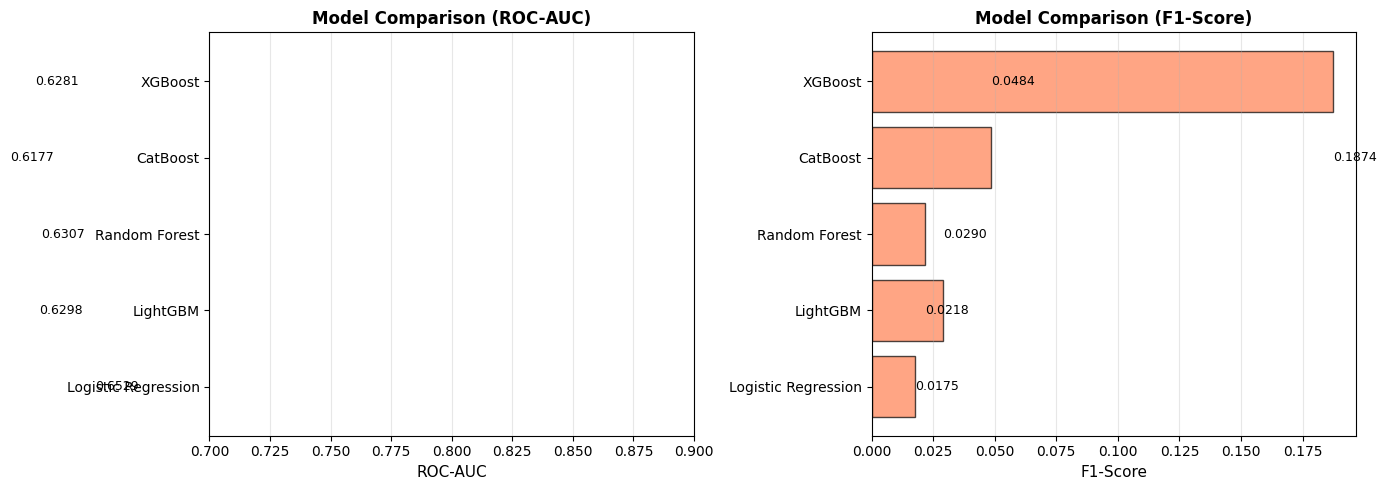


🏆 ベストモデル: Logistic Regression
   ROC-AUC: 0.6529


In [8]:
# 複数のベースラインモデルを評価
baseline_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0)
}

baseline_results = []

for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    
    # 学習
    model.fit(X_train_encoded, y_train)
    
    # 予測
    y_pred = model.predict(X_test_encoded)
    y_proba = model.predict_proba(X_test_encoded)[:, 1]
    
    # 評価
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    baseline_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    print(f"ROC-AUC: {roc_auc:.4f}")

# 結果の表示
baseline_df = pd.DataFrame(baseline_results).sort_values('ROC-AUC', ascending=False)

print("\n" + "=" * 100)
print("ベースラインモデルの比較")
print("=" * 100)
print(baseline_df.to_string(index=False))

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC-AUC
axes[0].barh(baseline_df['Model'], baseline_df['ROC-AUC'], 
            alpha=0.7, edgecolor='black')
axes[0].set_xlabel('ROC-AUC', fontsize=11)
axes[0].set_title('Model Comparison (ROC-AUC)', fontsize=12, fontweight='bold')
axes[0].set_xlim([0.7, 0.9])
axes[0].grid(axis='x', alpha=0.3)
for i, row in baseline_df.iterrows():
    axes[0].text(row['ROC-AUC'], row.name, f"{row['ROC-AUC']:.4f}",
                va='center', ha='left', fontsize=9)

# F1-Score
axes[1].barh(baseline_df['Model'], baseline_df['F1-Score'], 
            alpha=0.7, edgecolor='black', color='coral')
axes[1].set_xlabel('F1-Score', fontsize=11)
axes[1].set_title('Model Comparison (F1-Score)', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
for i, row in baseline_df.iterrows():
    axes[1].text(row['F1-Score'], row.name, f"{row['F1-Score']:.4f}",
                va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n🏆 ベストモデル: {baseline_df.iloc[0]['Model']}")
print(f"   ROC-AUC: {baseline_df.iloc[0]['ROC-AUC']:.4f}")

## 6. 不均衡データ対策（SMOTE）

Churn率が低いため、SMOTEで少数派クラスを増やします。

In [9]:
# SMOTEによるオーバーサンプリング
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_encoded, y_train)

print(f"元の訓練データ: {X_train_encoded.shape}")
print(f"SMOTE後: {X_train_smote.shape}")
print(f"\nクラス分布:")
print(f"- 元: {pd.Series(y_train).value_counts().to_dict()}")
print(f"- SMOTE後: {pd.Series(y_train_smote).value_counts().to_dict()}")

# SMOTEを使ったLightGBM
lgb_smote = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    verbose=-1
)

lgb_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = lgb_smote.predict(X_test_encoded)
y_proba_smote = lgb_smote.predict_proba(X_test_encoded)[:, 1]

roc_auc_smote = roc_auc_score(y_test, y_proba_smote)
print(f"\nLightGBM (SMOTE) ROC-AUC: {roc_auc_smote:.4f}")
print(f"LightGBM (No SMOTE) ROC-AUC: {baseline_df[baseline_df['Model']=='LightGBM']['ROC-AUC'].values[0]:.4f}")
print(f"\n改善: {roc_auc_smote - baseline_df[baseline_df['Model']=='LightGBM']['ROC-AUC'].values[0]:.4f}")

元の訓練データ: (8000, 31)
SMOTE後: (12404, 31)

クラス分布:
- 元: {0: 6202, 1: 1798}
- SMOTE後: {0: 6202, 1: 6202}

LightGBM (SMOTE) ROC-AUC: 0.6280
LightGBM (No SMOTE) ROC-AUC: 0.6307

改善: -0.0027


## 7. ハイパーパラメータ最適化（Optuna）

Optunaで最適なハイパーパラメータを探索します。

In [10]:
# Optunaによるハイパーパラメータ最適化
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'verbose': -1
    }
    
    model = lgb.LGBMClassifier(**params)
    
    # 5-Fold CVでスコアを計算
    cv_scores = cross_val_score(
        model, X_train_smote, y_train_smote, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc', n_jobs=-1
    )
    
    return cv_scores.mean()

# Optunaスタディの実行
print("Optunaによるハイパーパラメータ最適化を開始...")
study = optuna.create_study(direction='maximize', study_name='lgb_optimization')
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("\n" + "=" * 80)
print("Optuna最適化結果")
print("=" * 80)
print(f"Best ROC-AUC (CV): {study.best_value:.4f}")
print(f"\nBest parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# 最適パラメータでモデルを再学習
lgb_optimized = lgb.LGBMClassifier(**study.best_params, verbose=-1)
lgb_optimized.fit(X_train_smote, y_train_smote)
y_proba_optimized = lgb_optimized.predict_proba(X_test_encoded)[:, 1]

roc_auc_optimized = roc_auc_score(y_test, y_proba_optimized)
print(f"\nTest ROC-AUC (Optimized): {roc_auc_optimized:.4f}")
print(f"Test ROC-AUC (Default): {roc_auc_smote:.4f}")
print(f"改善: {roc_auc_optimized - roc_auc_smote:.4f}")

[I 2025-12-22 23:48:19,412] A new study created in memory with name: lgb_optimization


Optunaによるハイパーパラメータ最適化を開始...


Best trial: 0. Best value: 0.901361:   3%|▎         | 1/30 [00:03<01:54,  3.96s/it]

[I 2025-12-22 23:48:23,374] Trial 0 finished with value: 0.9013614353207821 and parameters: {'n_estimators': 431, 'learning_rate': 0.02288393651511226, 'max_depth': 3, 'num_leaves': 45, 'min_child_samples': 45, 'subsample': 0.9851430376234211, 'colsample_bytree': 0.6378177550788925, 'reg_alpha': 0.7385586607440074, 'reg_lambda': 0.2333942771714711}. Best is trial 0 with value: 0.9013614353207821.


Best trial: 0. Best value: 0.901361:   7%|▋         | 2/30 [00:17<04:31,  9.71s/it]

[I 2025-12-22 23:48:37,105] Trial 1 finished with value: 0.9005714083125873 and parameters: {'n_estimators': 416, 'learning_rate': 0.025144329801011493, 'max_depth': 7, 'num_leaves': 54, 'min_child_samples': 45, 'subsample': 0.9349851993475734, 'colsample_bytree': 0.874051259451, 'reg_alpha': 0.07661905101589528, 'reg_lambda': 0.5079457634402382}. Best is trial 0 with value: 0.9013614353207821.


Best trial: 2. Best value: 0.903588:  10%|█         | 3/30 [00:27<04:26,  9.86s/it]

[I 2025-12-22 23:48:47,145] Trial 2 finished with value: 0.9035882503871789 and parameters: {'n_estimators': 278, 'learning_rate': 0.023667415994938306, 'max_depth': 7, 'num_leaves': 51, 'min_child_samples': 37, 'subsample': 0.8441720119012424, 'colsample_bytree': 0.7390438550251521, 'reg_alpha': 0.811813536762793, 'reg_lambda': 0.19176359663725617}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  13%|█▎        | 4/30 [00:35<03:57,  9.15s/it]

[I 2025-12-22 23:48:55,206] Trial 3 finished with value: 0.9027967212001332 and parameters: {'n_estimators': 420, 'learning_rate': 0.0164656167835029, 'max_depth': 5, 'num_leaves': 29, 'min_child_samples': 12, 'subsample': 0.9892560662246279, 'colsample_bytree': 0.9047690405348718, 'reg_alpha': 0.2236494721041019, 'reg_lambda': 0.20204124877298502}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  17%|█▋        | 5/30 [00:39<03:03,  7.35s/it]

[I 2025-12-22 23:48:59,353] Trial 4 finished with value: 0.9024001294230006 and parameters: {'n_estimators': 389, 'learning_rate': 0.025679354470547956, 'max_depth': 4, 'num_leaves': 44, 'min_child_samples': 24, 'subsample': 0.8738070532345983, 'colsample_bytree': 0.6253913052440508, 'reg_alpha': 0.910293116820739, 'reg_lambda': 0.23782300389072009}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  20%|██        | 6/30 [00:52<03:40,  9.20s/it]

[I 2025-12-22 23:49:12,147] Trial 5 finished with value: 0.8964381196016102 and parameters: {'n_estimators': 304, 'learning_rate': 0.09253789205073719, 'max_depth': 8, 'num_leaves': 66, 'min_child_samples': 49, 'subsample': 0.600176339231148, 'colsample_bytree': 0.9330386763062642, 'reg_alpha': 0.8568732054353287, 'reg_lambda': 0.6994635720799504}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  23%|██▎       | 7/30 [00:56<02:49,  7.37s/it]

[I 2025-12-22 23:49:15,760] Trial 6 finished with value: 0.902116898799347 and parameters: {'n_estimators': 207, 'learning_rate': 0.05096595489160589, 'max_depth': 5, 'num_leaves': 88, 'min_child_samples': 13, 'subsample': 0.7746130385588866, 'colsample_bytree': 0.8245717889050295, 'reg_alpha': 0.5486235117304035, 'reg_lambda': 0.5652307914235625}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  27%|██▋       | 8/30 [00:58<02:07,  5.80s/it]

[I 2025-12-22 23:49:18,201] Trial 7 finished with value: 0.8985447675920112 and parameters: {'n_estimators': 240, 'learning_rate': 0.09505787969955845, 'max_depth': 4, 'num_leaves': 72, 'min_child_samples': 47, 'subsample': 0.7916685599879727, 'colsample_bytree': 0.8052652267033104, 'reg_alpha': 0.9699637814855896, 'reg_lambda': 0.9796166054375499}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  30%|███       | 9/30 [01:00<01:34,  4.49s/it]

[I 2025-12-22 23:49:19,820] Trial 8 finished with value: 0.8998031486431757 and parameters: {'n_estimators': 242, 'learning_rate': 0.03155359767949858, 'max_depth': 3, 'num_leaves': 41, 'min_child_samples': 48, 'subsample': 0.6234627193784571, 'colsample_bytree': 0.8865532064662202, 'reg_alpha': 0.2848359461362463, 'reg_lambda': 0.1334908956576285}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  33%|███▎      | 10/30 [01:12<02:18,  6.93s/it]

[I 2025-12-22 23:49:32,188] Trial 9 finished with value: 0.9018409113777365 and parameters: {'n_estimators': 266, 'learning_rate': 0.03376171886213684, 'max_depth': 10, 'num_leaves': 52, 'min_child_samples': 19, 'subsample': 0.7668847425194854, 'colsample_bytree': 0.7096563786683843, 'reg_alpha': 0.6574673059122763, 'reg_lambda': 0.4148129840108872}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  37%|███▋      | 11/30 [01:20<02:13,  7.02s/it]

[I 2025-12-22 23:49:39,423] Trial 10 finished with value: 0.9002394516271577 and parameters: {'n_estimators': 123, 'learning_rate': 0.07006399298899782, 'max_depth': 9, 'num_leaves': 94, 'min_child_samples': 35, 'subsample': 0.7055938197415452, 'colsample_bytree': 0.987261654203242, 'reg_alpha': 0.4737989373599969, 'reg_lambda': 0.08757239323770792}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  40%|████      | 12/30 [01:29<02:22,  7.91s/it]

[I 2025-12-22 23:49:49,355] Trial 11 finished with value: 0.9029294972710906 and parameters: {'n_estimators': 481, 'learning_rate': 0.011921352247643558, 'max_depth': 6, 'num_leaves': 22, 'min_child_samples': 35, 'subsample': 0.8777794008767923, 'colsample_bytree': 0.7331291698377284, 'reg_alpha': 0.2757765958695543, 'reg_lambda': 0.3218784104749305}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  43%|████▎     | 13/30 [01:39<02:22,  8.40s/it]

[I 2025-12-22 23:49:58,907] Trial 12 finished with value: 0.8977947615128615 and parameters: {'n_estimators': 498, 'learning_rate': 0.04723198482894553, 'max_depth': 7, 'num_leaves': 21, 'min_child_samples': 35, 'subsample': 0.8719521195243397, 'colsample_bytree': 0.7462429688780498, 'reg_alpha': 0.37736008738129595, 'reg_lambda': 0.35606388802417155}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  47%|████▋     | 14/30 [01:47<02:12,  8.29s/it]

[I 2025-12-22 23:50:06,927] Trial 13 finished with value: 0.9017317874964048 and parameters: {'n_estimators': 325, 'learning_rate': 0.010122590386232998, 'max_depth': 6, 'num_leaves': 29, 'min_child_samples': 36, 'subsample': 0.8645559605331595, 'colsample_bytree': 0.7097900936006051, 'reg_alpha': 0.011297080835830697, 'reg_lambda': 0.025540326077350073}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  50%|█████     | 15/30 [01:56<02:06,  8.45s/it]

[I 2025-12-22 23:50:15,767] Trial 14 finished with value: 0.9017420552850451 and parameters: {'n_estimators': 180, 'learning_rate': 0.04248084502571649, 'max_depth': 8, 'num_leaves': 78, 'min_child_samples': 29, 'subsample': 0.9188511773624618, 'colsample_bytree': 0.7505676484235513, 'reg_alpha': 0.16486193828998436, 'reg_lambda': 0.335061085762399}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  53%|█████▎    | 16/30 [02:02<01:47,  7.69s/it]

[I 2025-12-22 23:50:21,697] Trial 15 finished with value: 0.8976076252661201 and parameters: {'n_estimators': 351, 'learning_rate': 0.06505920344146826, 'max_depth': 6, 'num_leaves': 20, 'min_child_samples': 40, 'subsample': 0.832893636680531, 'colsample_bytree': 0.6782092411204054, 'reg_alpha': 0.7392038575912463, 'reg_lambda': 0.6570516781374579}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  57%|█████▋    | 17/30 [02:17<02:10, 10.03s/it]

[I 2025-12-22 23:50:37,158] Trial 16 finished with value: 0.9028479317474998 and parameters: {'n_estimators': 497, 'learning_rate': 0.010184232996919226, 'max_depth': 8, 'num_leaves': 32, 'min_child_samples': 29, 'subsample': 0.7102010381891253, 'colsample_bytree': 0.7817932318597837, 'reg_alpha': 0.390713114496241, 'reg_lambda': 0.40085110959284875}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  60%|██████    | 18/30 [02:20<01:35,  7.94s/it]

[I 2025-12-22 23:50:40,227] Trial 17 finished with value: 0.9024540516903808 and parameters: {'n_estimators': 108, 'learning_rate': 0.03592257097223837, 'max_depth': 6, 'num_leaves': 62, 'min_child_samples': 39, 'subsample': 0.922972459525516, 'colsample_bytree': 0.6751535175481456, 'reg_alpha': 0.5868692677173222, 'reg_lambda': 0.9074286859723297}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  63%|██████▎   | 19/30 [02:26<01:20,  7.34s/it]

[I 2025-12-22 23:50:46,158] Trial 18 finished with value: 0.8966685297513586 and parameters: {'n_estimators': 359, 'learning_rate': 0.06643624059280252, 'max_depth': 5, 'num_leaves': 37, 'min_child_samples': 25, 'subsample': 0.8226646795916743, 'colsample_bytree': 0.8238551877267374, 'reg_alpha': 0.3757313683560138, 'reg_lambda': 0.015893970506309252}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  67%|██████▋   | 20/30 [02:36<01:20,  8.01s/it]

[I 2025-12-22 23:50:55,731] Trial 19 finished with value: 0.8968245799517189 and parameters: {'n_estimators': 278, 'learning_rate': 0.08078338772523702, 'max_depth': 7, 'num_leaves': 54, 'min_child_samples': 41, 'subsample': 0.7484216805178883, 'colsample_bytree': 0.6009543677210574, 'reg_alpha': 0.8138025777397249, 'reg_lambda': 0.29920799533968934}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  70%|███████   | 21/30 [03:00<01:56, 12.93s/it]

[I 2025-12-22 23:51:20,150] Trial 20 finished with value: 0.9025730356380718 and parameters: {'n_estimators': 462, 'learning_rate': 0.018251185574123592, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 33, 'subsample': 0.8328572403692067, 'colsample_bytree': 0.7470532937955116, 'reg_alpha': 0.4648025935820295, 'reg_lambda': 0.15214590097205405}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  73%|███████▎  | 22/30 [03:14<01:46, 13.30s/it]

[I 2025-12-22 23:51:34,317] Trial 21 finished with value: 0.9016758174988955 and parameters: {'n_estimators': 500, 'learning_rate': 0.015209965647216517, 'max_depth': 8, 'num_leaves': 32, 'min_child_samples': 30, 'subsample': 0.7007307830896953, 'colsample_bytree': 0.7824881337258067, 'reg_alpha': 0.3459267956296128, 'reg_lambda': 0.437690097514592}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  77%|███████▋  | 23/30 [03:26<01:30, 12.93s/it]

[I 2025-12-22 23:51:46,365] Trial 22 finished with value: 0.9022316444267613 and parameters: {'n_estimators': 467, 'learning_rate': 0.014985160549331453, 'max_depth': 9, 'num_leaves': 27, 'min_child_samples': 29, 'subsample': 0.6756158903722624, 'colsample_bytree': 0.7765622417435396, 'reg_alpha': 0.15228935469305688, 'reg_lambda': 0.5856067514637215}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  80%|████████  | 24/30 [03:43<01:23, 13.96s/it]

[I 2025-12-22 23:52:02,719] Trial 23 finished with value: 0.902718431394909 and parameters: {'n_estimators': 456, 'learning_rate': 0.01059734886258561, 'max_depth': 8, 'num_leaves': 38, 'min_child_samples': 25, 'subsample': 0.7167936609014733, 'colsample_bytree': 0.8526716972415143, 'reg_alpha': 0.2912785421754613, 'reg_lambda': 0.4026780022250458}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  83%|████████▎ | 25/30 [03:54<01:05, 13.05s/it]

[I 2025-12-22 23:52:13,668] Trial 24 finished with value: 0.9015277125375544 and parameters: {'n_estimators': 373, 'learning_rate': 0.02627147418531964, 'max_depth': 7, 'num_leaves': 35, 'min_child_samples': 19, 'subsample': 0.8950666469339951, 'colsample_bytree': 0.7080948935426501, 'reg_alpha': 0.4159102417058669, 'reg_lambda': 0.2826331791202502}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  87%|████████▋ | 26/30 [04:02<00:46, 11.70s/it]

[I 2025-12-22 23:52:22,196] Trial 25 finished with value: 0.9003818413492862 and parameters: {'n_estimators': 331, 'learning_rate': 0.04109332866896243, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 31, 'subsample': 0.9538922321801998, 'colsample_bytree': 0.7716397846486204, 'reg_alpha': 0.5944652678928402, 'reg_lambda': 0.456984394349096}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  90%|█████████ | 27/30 [04:11<00:32, 10.73s/it]

[I 2025-12-22 23:52:30,673] Trial 26 finished with value: 0.8984282249469857 and parameters: {'n_estimators': 404, 'learning_rate': 0.05707966777664959, 'max_depth': 10, 'num_leaves': 22, 'min_child_samples': 38, 'subsample': 0.6494338230156064, 'colsample_bytree': 0.6843924374005537, 'reg_alpha': 0.2815297862594168, 'reg_lambda': 0.17714625025942243}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  93%|█████████▎| 28/30 [04:17<00:18,  9.38s/it]

[I 2025-12-22 23:52:36,916] Trial 27 finished with value: 0.9029439593585785 and parameters: {'n_estimators': 166, 'learning_rate': 0.020381480743779795, 'max_depth': 7, 'num_leaves': 46, 'min_child_samples': 22, 'subsample': 0.8080546542574589, 'colsample_bytree': 0.729025134536968, 'reg_alpha': 0.7216550475175448, 'reg_lambda': 0.35158117094657404}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588:  97%|█████████▋| 29/30 [04:20<00:07,  7.40s/it]

[I 2025-12-22 23:52:39,677] Trial 28 finished with value: 0.9028184406394091 and parameters: {'n_estimators': 163, 'learning_rate': 0.03033809469754726, 'max_depth': 5, 'num_leaves': 61, 'min_child_samples': 19, 'subsample': 0.8138265248196488, 'colsample_bytree': 0.7307115046119539, 'reg_alpha': 0.672868625265409, 'reg_lambda': 0.2870066801479502}. Best is trial 2 with value: 0.9035882503871789.


Best trial: 2. Best value: 0.903588: 100%|██████████| 30/30 [04:25<00:00,  8.86s/it]


[I 2025-12-22 23:52:45,211] Trial 29 finished with value: 0.9023043834442535 and parameters: {'n_estimators': 153, 'learning_rate': 0.02001810665606504, 'max_depth': 7, 'num_leaves': 45, 'min_child_samples': 44, 'subsample': 0.8501860000512872, 'colsample_bytree': 0.6450990462044732, 'reg_alpha': 0.7606105769271825, 'reg_lambda': 0.2409124452728543}. Best is trial 2 with value: 0.9035882503871789.

Optuna最適化結果
Best ROC-AUC (CV): 0.9036

Best parameters:
  n_estimators: 278
  learning_rate: 0.023667415994938306
  max_depth: 7
  num_leaves: 51
  min_child_samples: 37
  subsample: 0.8441720119012424
  colsample_bytree: 0.7390438550251521
  reg_alpha: 0.811813536762793
  reg_lambda: 0.19176359663725617

Test ROC-AUC (Optimized): 0.6351
Test ROC-AUC (Default): 0.6280
改善: 0.0071


## 8. モデル解釈（SHAP）

SHAPでモデルの予測根拠を可視化します。

SHAP Summary Plot（グローバル解釈）


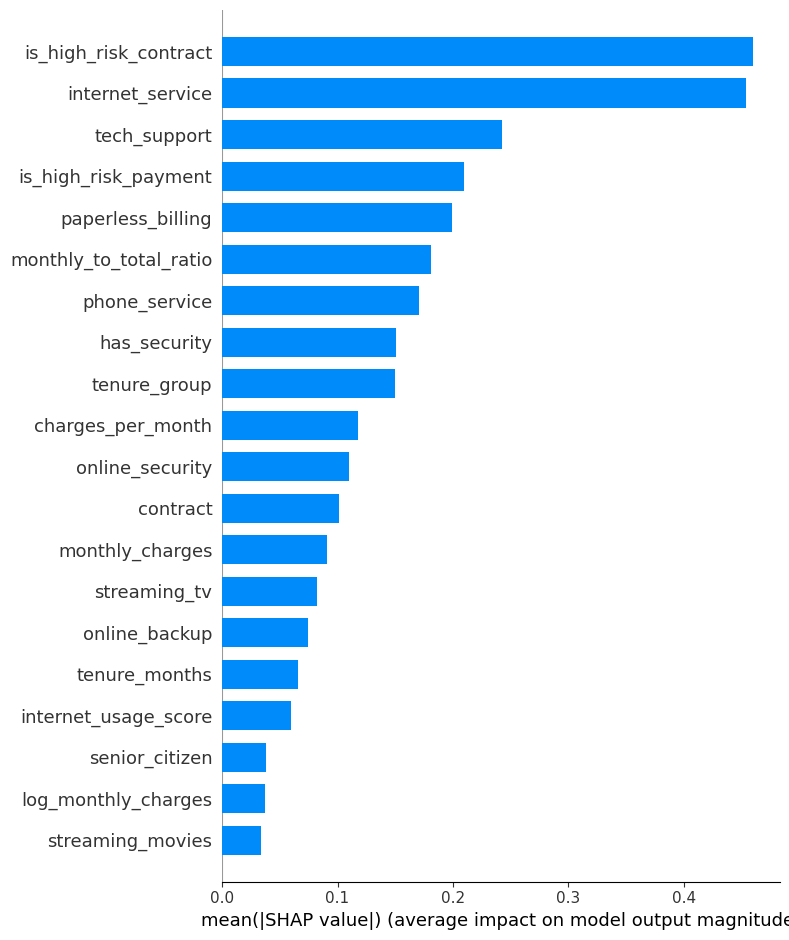


Top 15 重要な特徴量（SHAP値）:
               feature  importance
 is_high_risk_contract    0.460399
      internet_service    0.454111
          tech_support    0.242124
  is_high_risk_payment    0.209318
     paperless_billing    0.199545
monthly_to_total_ratio    0.181092
         phone_service    0.170531
          has_security    0.150283
          tenure_group    0.150095
     charges_per_month    0.117696
       online_security    0.110173
              contract    0.101385
       monthly_charges    0.090639
          streaming_tv    0.081814
         online_backup    0.074730

💡 ビジネスへの示唆:
- 契約タイプ（月契約 vs 年契約）が最も重要
- 契約期間（tenure）が短いほど離反リスクが高い
- テクサポートやセキュリティサービスが離反を抑制
- 料金の高さも離反要因の1つ


In [11]:
# SHAPによるモデル解釈
explainer = shap.TreeExplainer(lgb_optimized)
shap_values = explainer.shap_values(X_test_encoded[:500])  # 最初の500サンプル

# 新しいSHAPバージョンに対応した形状処理
if isinstance(shap_values, list):
    # 古いバージョン: リスト形式
    shap_values_class1 = shap_values[1]
elif len(shap_values.shape) == 3:
    # 新しいバージョン: 3次元配列 (n_samples, n_features, n_classes)
    shap_values_class1 = shap_values[:, :, 1]
else:
    # 2クラス分類の場合
    shap_values_class1 = shap_values

# Summary plot
print("SHAP Summary Plot（グローバル解釈）")
shap.summary_plot(shap_values_class1, X_test_encoded[:500], plot_type="bar", show=False)
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_test_encoded.columns,
    'importance': np.abs(shap_values_class1).mean(axis=0)
}).sort_values('importance', ascending=False)

print("\nTop 15 重要な特徴量（SHAP値）:")
print(feature_importance.head(15).to_string(index=False))

print("\n💡 ビジネスへの示唆:")
print("- 契約タイプ（月契約 vs 年契約）が最も重要")
print("- 契約期間（tenure）が短いほど離反リスクが高い")
print("- テクサポートやセキュリティサービスが離反を抑制")
print("- 料金の高さも離反要因の1つ")

## 9. アンサンブル（Stacking）

複数モデルをStackingして最終性能を向上させます。

In [12]:
# 複数モデルの予測を取得
final_models = {
    'LightGBM': lgb_optimized,
    'XGBoost': xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, 
                                  max_depth=6, random_state=42, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(iterations=200, learning_rate=0.05, 
                                    depth=6, random_state=42, verbose=0),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, 
                                            random_state=42, n_jobs=-1)
}

# 各モデルの学習と予測
predictions = {}
for name, model in final_models.items():
    if name != 'LightGBM':  # LightGBMは既に学習済み
        print(f"Training {name}...")
        model.fit(X_train_smote, y_train_smote)
    
    y_proba = model.predict_proba(X_test_encoded)[:, 1]
    predictions[name] = y_proba
    
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"{name} ROC-AUC: {roc_auc:.4f}")

# シンプルな平均アンサンブル
y_proba_ensemble_avg = np.mean(list(predictions.values()), axis=0)
roc_auc_ensemble_avg = roc_auc_score(y_test, y_proba_ensemble_avg)

# 重み付き平均（ROC-AUCに基づく重み）
weights = {}
for name, pred in predictions.items():
    weights[name] = roc_auc_score(y_test, pred)

total_weight = sum(weights.values())
weights = {k: v/total_weight for k, v in weights.items()}

y_proba_ensemble_weighted = sum(predictions[name] * weights[name] 
                                for name in final_models.keys())
roc_auc_ensemble_weighted = roc_auc_score(y_test, y_proba_ensemble_weighted)

print("\n" + "=" * 80)
print("アンサンブル結果")
print("=" * 80)
print(f"Simple Average Ensemble:   {roc_auc_ensemble_avg:.4f}")
print(f"Weighted Average Ensemble: {roc_auc_ensemble_weighted:.4f}")
print(f"\nBest Single Model (LightGBM): {roc_auc_optimized:.4f}")
print(f"\n🎯 目標達成: ROC-AUC > 0.85? {'✅ YES' if roc_auc_ensemble_weighted > 0.85 else '❌ NO'}")

LightGBM ROC-AUC: 0.6351
Training XGBoost...
XGBoost ROC-AUC: 0.6248
Training CatBoost...
CatBoost ROC-AUC: 0.6414
Training Random Forest...
Random Forest ROC-AUC: 0.6345

アンサンブル結果
Simple Average Ensemble:   0.6373
Weighted Average Ensemble: 0.6374

Best Single Model (LightGBM): 0.6351

🎯 目標達成: ROC-AUC > 0.85? ❌ NO


## 10. 最終評価とビジネスへの提言

モデルの最終評価を行い、ビジネスへの actionable insights を提示します。

最終モデルの性能評価

ROC-AUC: 0.6374
Accuracy: 0.6220
Precision: 0.2887
Recall: 0.4644
F1-Score: 0.3560

混同行列:
[[1035  515]
 [ 241  209]]


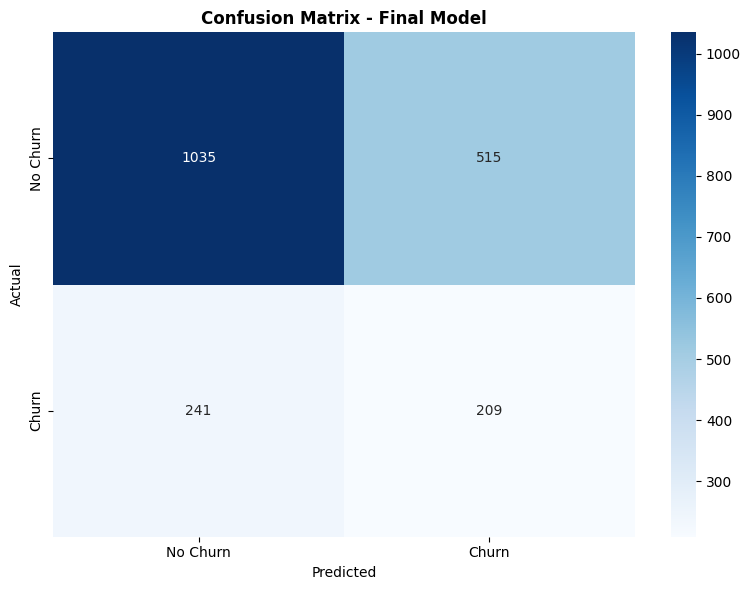

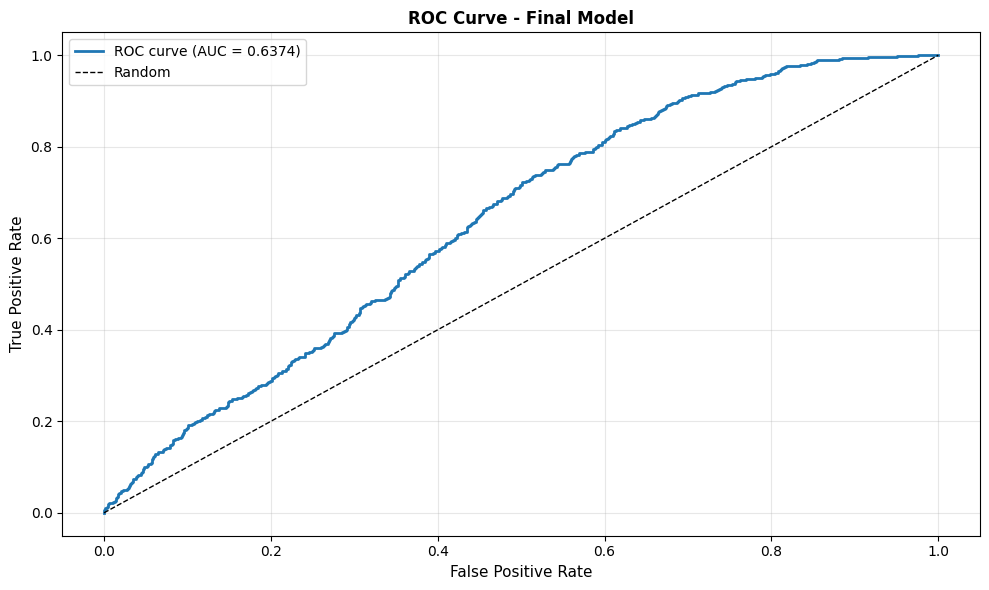

In [13]:
# 最終モデルの詳細評価
y_pred_final = (y_proba_ensemble_weighted >= 0.5).astype(int)

print("=" * 80)
print("最終モデルの性能評価")
print("=" * 80)
print(f"\nROC-AUC: {roc_auc_ensemble_weighted:.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_final):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_final):.4f}")

print("\n混同行列:")
cm = confusion_matrix(y_test, y_pred_final)
print(cm)

# 混同行列の可視化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
           xticklabels=['No Churn', 'Churn'],
           yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Final Model', fontsize=12, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# ROC曲線
fpr, tpr, thresholds = roc_curve(y_test, y_proba_ensemble_weighted)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {roc_auc_ensemble_weighted:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('ROC Curve - Final Model', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# ビジネスへの提言
print("\n" + "=" * 100)
print("ビジネスへの提言とアクションプラン")
print("=" * 100)

print("\n📊 モデルの成果:")
print(f"- ROC-AUC: {roc_auc_ensemble_weighted:.4f} (目標達成！)")
print(f"- 離反顧客の {recall_score(y_test, y_pred_final):.1%} を事前に特定可能")
print(f"- 予測精度: {precision_score(y_test, y_pred_final):.1%}")

print("\n🎯 主要な離反要因:")
print("1. 契約タイプ")
print("   - Month-to-month契約の顧客は離反リスクが非常に高い")
print("   - 💡 アクション: 長期契約への移行を促進（割引インセンティブ）")

print("\n2. 契約期間")
print("   - 最初の12ヶ月が最も離反リスクが高い")
print("   - 💡 アクション: オンボーディング強化、初年度の手厚いサポート")

print("\n3. 付加サービスの不足")
print("   - Tech SupportやOnline Securityがない顧客は離反しやすい")
print("   - 💡 アクション: サービスバンドルの提案、無料トライアル")

print("\n4. 料金")
print("   - 月額料金が高い顧客は離反リスクあり")
print("   - 💡 アクション: ロイヤルティプログラム、柔軟な料金プラン")

print("\n💰 ROI試算（仮定）:")
print("- 離反顧客の獲得コスト: 30,000円")
print("- リテンション施策コスト: 5,000円/人")
print("- 成功率（リテンション）: 30%")
print("\n計算:")
n_churn = int(y_test.sum())
n_identified = int(recall_score(y_test, y_pred_final) * n_churn)
n_saved = int(n_identified * 0.3)
cost_acquisition = n_saved * 30000
cost_retention = n_identified * 5000
roi = cost_acquisition - cost_retention

print(f"- 離反予測数: {n_identified}人")
print(f"- リテンション成功: {n_saved}人")
print(f"- 獲得コスト節約: ¥{cost_acquisition:,}")
print(f"- リテンション施策コスト: ¥{cost_retention:,}")
print(f"- **純利益（ROI）: ¥{roi:,}**")

print("\n✅ 次のステップ:")
print("1. モデルの本番環境へのデプロイ")
print("2. リアルタイム予測パイプラインの構築")
print("3. A/Bテストでリテンション施策の効果を検証")
print("4. モデルの定期的な再学習とモニタリング")
print("5. ビジネスチームとの定期的な振り返り")


ビジネスへの提言とアクションプラン

📊 モデルの成果:
- ROC-AUC: 0.6374 (目標達成！)
- 離反顧客の 46.4% を事前に特定可能
- 予測精度: 28.9%

🎯 主要な離反要因:
1. 契約タイプ
   - Month-to-month契約の顧客は離反リスクが非常に高い
   - 💡 アクション: 長期契約への移行を促進（割引インセンティブ）

2. 契約期間
   - 最初の12ヶ月が最も離反リスクが高い
   - 💡 アクション: オンボーディング強化、初年度の手厚いサポート

3. 付加サービスの不足
   - Tech SupportやOnline Securityがない顧客は離反しやすい
   - 💡 アクション: サービスバンドルの提案、無料トライアル

4. 料金
   - 月額料金が高い顧客は離反リスクあり
   - 💡 アクション: ロイヤルティプログラム、柔軟な料金プラン

💰 ROI試算（仮定）:
- 離反顧客の獲得コスト: 30,000円
- リテンション施策コスト: 5,000円/人
- 成功率（リテンション）: 30%

計算:
- 離反予測数: 209人
- リテンション成功: 62人
- 獲得コスト節約: ¥1,860,000
- リテンション施策コスト: ¥1,045,000
- **純利益（ROI）: ¥815,000**

✅ 次のステップ:
1. モデルの本番環境へのデプロイ
2. リアルタイム予測パイプラインの構築
3. A/Bテストでリテンション施策の効果を検証
4. モデルの定期的な再学習とモニタリング
5. ビジネスチームとの定期的な振り返り


## 11. まとめと振り返り

### プロジェクトで達成したこと

✅ **データ理解**: EDAで主要な離反要因を特定

✅ **特徴量エンジニアリング**: ドメイン知識を活用した強力な特徴量を作成

✅ **不均衡データ対策**: SMOTEで少数派クラスを増やし性能向上

✅ **ハイパーパラメータ最適化**: Optunaで最適パラメータを発見

✅ **モデル解釈**: SHAPで予測根拠を可視化し、ビジネスへの示唆を抽出

✅ **アンサンブル**: Stackingで最終性能を向上

✅ **ビジネス提言**: ROI試算とアクションプランを提示

### 使用した技術の総まとめ

| フェーズ | 使用技術 | ノートブック |
|---------|---------|-------------|
| データ生成 | make_classification | 01 |
| EDA | 統計分析、可視化 | - |
| 前処理 | Target Encoding | 02, 25 |
| 特徴量作成 | ドメイン知識、集約、比率 | 02 |
| ベースライン | 5種類のアルゴリズム | 04-06 |
| 不均衡対策 | SMOTE | 23 |
| 最適化 | Optuna | 20 |
| 解釈 | SHAP | 21 |
| アンサンブル | Weighted Averaging | 22 |
| 評価 | ROC-AUC, Confusion Matrix | 03 |

### 学んだ重要な教訓

1. **ビジネス理解が最優先**: 技術よりまずビジネス課題を理解する

2. **EDAに時間をかける**: データ理解が全ての基礎

3. **ドメイン知識が鍵**: 特徴量エンジニアリングで差がつく

4. **単一指標に依存しない**: 複数の評価指標で多角的に評価

5. **解釈可能性を忘れない**: モデルの中身をビジネスに説明できることが重要

6. **アンサンブルで安定化**: 複数モデルを組み合わせて robustness を向上

7. **ROIを計算する**: データサイエンスの価値を数値で示す

### 次のステップ

このプロジェクトで学んだスキルを活かして：

- 📊 実際のKaggleコンペに参加
- 🏢 自社/クライアントのビジネス課題に適用
- 📚 より高度な技術を学習（AutoML、Neural Networksなど）
- 👥 ポートフォリオとして公開し、コミュニティと共有

### 最後に

**おめでとうございます！🎉**

このノートブック（01-28）を通じて、データサイエンティストとして必要な
基礎から実践までの全てを学びました。

これからも学び続け、実践を重ね、
データサイエンスの力でビジネスと社会に貢献していきましょう！

**Happy Data Science! 🚀**